# Particionamiento del Dataset: Million Playlist Dataset (MPD)

## Descripción del Dataset (D)

La base de datos utilizada en este proyecto es el **Million Playlist Dataset**, desarrollado por Spotify para el RecSys Challenge 2018. Contiene un millón de playlists públicas creadas por usuarios en Estados Unidos entre 2010 y 2017. Cada playlist incluye metadatos como su título, cantidad de canciones, duración total, número de artistas únicos, número de álbumes, número de ediciones, si es colaborativa o no, y un arreglo con todas las canciones que contiene. El objetivo es analizar comportamientos musicales y patrones de curaduría de los usuarios.


---

## Reglas de Particionamiento

Para dividir el dataset original `D` en subconjuntos significativos, se utilizaron dos variables de caracterización:

- `playlist.collaborative` → indica si la playlist fue construida de manera colaborativa (True) o no (False).
- `playlist.num_tracks` → número de canciones en la playlist, agrupado en tres categorías:
    - **Corta**: 5–30 canciones
    - **Media**: 31–100 canciones
    - **Larga**: más de 100 canciones

Esto generó **6 combinaciones posibles**, que se detallan a continuación:

1. `No colaborativa` + `Corta`
2. `No colaborativa` + `Media`
3. `No colaborativa` + `Larga`
4. `Colaborativa` + `Corta`
5. `Colaborativa` + `Media`
6. `Colaborativa` + `Larga`

Cada combinación representa una **regla de particionamiento**, y será usada para extraer subconjuntos de datos.

---

## Marco teorico

El aprendizaje automático  se clasifica principalmente en dos grandes categorías: aprendizaje supervisado y aprendizaje no supervisado. Ambos estan enfocados en que las  máquinas aprendan a partir de datos, pero con diferentes objetivos y metodologías.

---------Aprendizaje Supervisado-----------
El modelo se entrena con un conjunto de datos etiquetado, es decir, cada entrada está asociada a una salida o clase conocida. El objetivo es que el modelo aprenda a predecir o clasificar correctamente nuevas entradas con base a la entrada, es decir ya se conocen los datos.

Algoritmos representativos:

Regresión lineal: para predecir valores continuos.

Regresión logística: para clasificación binaria o multiclase.

Árboles de decisión: estructura jerárquica que divide el espacio de decisión.

Random Forest: conjunto de árboles que mejora la generalización.

Máquinas de vectores de soporte : encuentra el hiperplano óptimo para separar clases.

Redes neuronales: modelos complejos inspirados en el cerebro humano.

En PySpark , los algoritmos supervisados disponibles son:

    1-LinearRegression

    2-LogisticRegression

    3-DecisionTreeClassifier

    4-RandomForestClassifier

    5-GBTClassifier (Gradient-Boosted Trees)

    6-MultilayerPerceptronClassifier

---------Aprendizaje No Supervisado---------
El aprendizaje no supervisado trabaja con datos no etiquetados. El objetivo es descubrir estructuras o patrones ocultos en los datos, como agrupamientos o relaciones, al contrario del supervisado no se conocen los datos. Su relacion entre ellos

Algoritmos representativos:

K-Means: agrupa los datos en k grupos basados en su similitud.

Clustering jerárquico: construye un árbol de grupos.

Análisis de componentes principales (PCA): reducción de dimensiones.

DBSCAN: agrupamiento basado en densidad, tolerante al ruido.

En PySpark, los algoritmos no supervisados disponibles son:

    1-KMeans

    2-BisectingKMeans

    3-GaussianMixture

    4-PCA (para reducción de dimensiones)

## Carga de Datos (PySpark)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, explode
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import os
import findspark
import glob
from functools import reduce
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, round
from functools import reduce
from pyspark.sql.functions import lit
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Función para inicializar Spark
def iniciar_spark(app_name="Spotify", memory="28g"):
    print("Iniciando Spark...")
    os.environ["SPARK_LOCAL_DIRS"] = "C:\\Users\\52614\\AppData\\Local\\Temp"
    findspark.init()
    spark = SparkSession.builder \
        .appName(app_name) \
        .master("local[*]") \
        .config("spark.driver.memory", memory) \
        .getOrCreate()
    print("SparkSession iniciada correctamente.")
    return spark

# Función para leer archivos JSON por lotes
def leer_archivos_en_lotes(spark, ruta_base, batch_size=3):
    #Busca todos los arhicos json en en path que indique
    archivos = sorted(glob.glob(os.path.join(ruta_base, "*.json")))
    # Dividir los archivos en lotes para leerlos progresivamente , esto se hizo debido a la capicidad de la PC
    print(f"Total de archivos encontrados: {len(archivos)}")
    batches = [archivos[i:i + batch_size] for i in range(0, len(archivos), batch_size)]
    
    df_raw = None
    # Iterar sobre cada lote de archivos
    for idx, batch in enumerate(batches):
        #print(f"Leyendo lote {idx + 1}/{len(batches)} con {len(batch)} archivos...")
         # Leer el lote actual de archivos JSON con formato multiline
        temp_df = spark.read.option("multiline", "true").json(batch)
        df_raw = temp_df if df_raw is None else df_raw.unionByName(temp_df)
    
    print("Lectura completa.")
    return df_raw

# Ruta donde se encuentran los archivos JSON
ruta_base = r"D:\Mestria\Big data\spotify-million\versions\1\data"

spark = iniciar_spark()
df_raw = leer_archivos_en_lotes(spark, ruta_base)

# Explode del campo "playlists"
playlists_df = df_raw.select(explode("playlists").alias("playlist"))

# Clasificar tamaño de playlist
playlists_cat_df = playlists_df.withColumn(
    "size_category",
    when(col("playlist.num_tracks") <= 30, "Corta")
    .when((col("playlist.num_tracks") > 30) & (col("playlist.num_tracks") <= 100), "Media")
    .otherwise("Larga")
)
#Si se queire revisar , descomentar la parte , imprimirlo no se ve estetico para la entrega
#playlists_cat_df.show(5, truncate=False)

Iniciando Spark...
SparkSession iniciada correctamente.
Total de archivos encontrados: 1000
Lectura completa.


## 1 Construcción de la muestra M

In [3]:
# 1. No colaborativa + Corta
part_1 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Corta")
)
part_1.show(3)

# 2. No colaborativa + Media
part_2 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Media")
)
part_2.show(3)

# 3. No colaborativa + Larga
part_3 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Larga")
)
part_3.show(3)

# 4.No Colaborativa + Corta
part_4 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Corta")
)
part_4.show(3)

# 5.Colaborativa + Media
part_5 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Media")
)
part_5.show(3)

# 6. Colaborativa + Larga
part_6 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Larga")
)
part_6.show(3)


+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 433...|        Corta|
|{false, null, 340...|        Corta|
|{false, null, 429...|        Corta|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 115...|        Media|
|{false, null, 116...|        Media|
|{false, null, 140...|        Media|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 289...|        Larga|
|{false, null, 356...|        Larga|
|{false, null, 258...|        Larga|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{true, null, 5549...|        Corta|


## Verificación

In [4]:
# Verificar cuántos registros hay en cada partición
print("Partición 1:", part_1.count())
print("Partición 2:", part_2.count())
print("Partición 3:", part_3.count())
print("Partición 4:", part_4.count())
print("Partición 5:", part_5.count())
print("Partición 6:", part_6.count())


Partición 1: 303361
Partición 2: 463628
Partición 3: 210442
Partición 4: 5549
Partición 5: 10980
Partición 6: 6040


###  Tabla de subconjuntos de particionamiento generados

| ID de Partición | ¿Es colaborativa? | Tamaño de playlist  | Número de playlists |
|------------------|--------------------|----------------------|----------------------|
| Partición 1      | No                 | Corta (≤30 tracks)   | 303,361              |
| Partición 2      | No                 | Media (31–100)       | 463,628              |
| Partición 3      | No                 | Larga (>100)         | 210,442              |
| Partición 4      | Sí                 | Corta (≤30 tracks)   | 5,549                |
| Partición 5      | Sí                 | Media (31–100)       | 10,980               |
| Partición 6      | Sí                 | Larga (>100)         | 6,040                |


## 2 Construcción Train – Test

In [5]:
# Parámetros
sample_size = 100  # total por partición
particiones = [part_1, part_2, part_3, part_4, part_5, part_6]

# Función para tomar muestra balanceada desde una partición
def stratified_sample(df, label_col, n_total):
    # contar clases
    class_counts = df.groupBy(label_col).count().collect()
    classes = [row[label_col] for row in class_counts]
    n_per_class = n_total // len(classes)

    samples = [df.filter(col(label_col) == c).limit(n_per_class) for c in classes]
    return reduce(lambda d1, d2: d1.unionByName(d2), samples)

# Aplicar a cada partición
sampled_parts = [stratified_sample(part, "size_category", sample_size) for part in particiones]

# Unir todas las muestras en un solo DataFrame
sample_df = reduce(lambda df1, df2: df1.unionByName(df2), sampled_parts)

# Eliminar filas nulas
sample_df = sample_df.na.drop()

# (Opcional) Verificar balanceo final
sample_df.groupBy("size_category").count().show()




+-------------+-----+
|size_category|count|
+-------------+-----+
|        Corta|  200|
|        Media|  200|
|        Larga|  200|
+-------------+-----+



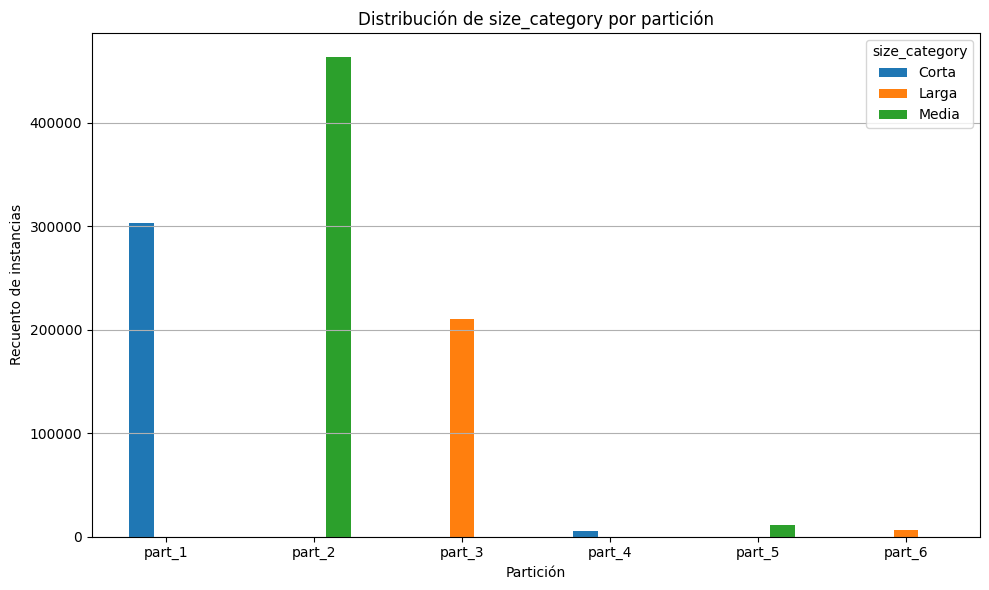

In [ ]:


#  Obtener la distribución de cada partición y etiquetarla
part_distributions = []

for i, part in enumerate(particiones, 1):
    df_dist = part.groupBy("size_category").count().orderBy("size_category")
    df_dist = df_dist.withColumn("particion", lit(f"part_{i}"))
    part_distributions.append(df_dist)

#  Unir todos en un solo DataFrame
all_parts_df = reduce(lambda d1, d2: d1.unionByName(d2), part_distributions)

#  Convertir a pandas para graficar
pdf_parts = all_parts_df.toPandas()

#  Crear gráfico de barras agrupadas
pivot_df = pdf_parts.pivot(index="particion", columns="size_category", values="count").fillna(0)
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("Distribución de size_category por partición")
plt.xlabel("Partición")
plt.ylabel("Recuento de instancias")
plt.xticks(rotation=0)
plt.legend(title="size_category")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



## 1. Validación cruzada y justificación del valor de *k*

Para evaluar la capacidad de generalización del modelo y medir la variabilidad de los resultados, se implementó un esquema de validación cruzada *k-fold* con **k = 5**. Esta elección se fundamenta en las siguientes razones específicas al conjunto de datos:

- **Tamaño de la muestra M**  
  La muestra `sample_df` fue construida a partir de 6 particiones (`Mi`), con 100 elementos cada una, dando un total de **600 registros**. Este volumen permite realizar una partición en 5 folds de 120 registros cada uno, manteniendo una cantidad adecuada para entrenamiento y validación en cada iteración.

- **Representatividad y balanceo de clases**  
  Los datos fueron estratificados por la variable `size_category` al construir la muestra, asegurando una distribución balanceada de las clases (`Corta`, `Media`, `Larga`). Esto permite que cada fold mantenga dicha proporción y sea representativo de la población general.

- **Relación entrenamiento / validación adecuada**  
  En cada iteración, el modelo se entrena con el 80% de los datos (480 registros) y se valida con el 20% restante (120 registros). Esta proporción permite que el modelo aprenda de una muestra robusta y sea evaluado con suficiente variedad.

- **Eficiencia computacional**  
  Considerando que la experimentación se realiza en entorno local y que el procesamiento de grandes volúmenes en PySpark puede ser costoso, **k = 5** ofrece un equilibrio entre confiabilidad y rendimiento, evitando tiempos excesivos de entrenamiento.

- **Consistencia con buenas prácticas**  
  El valor de k = 5 es ampliamente utilizado en la práctica cuando se cuenta con muestras moderadas. Permite estimar con precisión la variabilidad del modelo sin sobreajustar a subconjuntos muy pequeños ni sobredimensionar la carga computacional.

Por lo anterior, **se concluye que `k = 5` es una elección apropiada** para validar los resultados del modelo entrenado en este proyecto.


In [ ]:
from pyspark.sql.functions import col, rand, row_number
from pyspark.sql.window import Window
from functools import reduce

k = 5  # Número de folds

#  una columna de número aleatorio dentro de cada clase
window = Window.partitionBy("size_category").orderBy(rand())
sample_df = sample_df.withColumn("row_num", row_number().over(window))

 #Asignar el número de fold (balanceado por clase)
sample_df = sample_df.withColumn("fold", (col("row_num") % k).cast("int"))

# (Opcional) Verificar la distribución por clase y fold
sample_df.groupBy("size_category", "fold").count().orderBy("fold", "size_category").show()


+-------------+----+-----+
|size_category|fold|count|
+-------------+----+-----+
|        Corta|   0|   40|
|        Larga|   0|   40|
|        Media|   0|   40|
|        Corta|   1|   40|
|        Larga|   1|   40|
|        Media|   1|   40|
|        Corta|   2|   40|
|        Larga|   2|   40|
|        Media|   2|   40|
|        Corta|   3|   40|
|        Larga|   3|   40|
|        Media|   3|   40|
|        Corta|   4|   40|
|        Larga|   4|   40|
|        Media|   4|   40|
+-------------+----+-----+



## 3 Selección de métricas para medir calidad de resultados

**Precisión (Accuracy)**

Definición: Proporción de predicciones correctas sobre el total de instancias evaluadas.

Ventajas: Es sencilla de interpretar y rápida de calcular. Es útil cuando el conjunto de datos tiene clases equilibradas.

Aplicación en el proyecto: Se usa como métrica de referencia para evaluar el rendimiento general del modelo. No obstante, si las clases están desbalanceadas, puede ser engañosa y debe complementarse con otras métricas más específicas.

**Precisión ponderada (Weighted Precision)**

Definición: Promedio ponderado de la precisión por clase, considerando el número de instancias de cada clase.

Ventajas: Tiene en cuenta el desbalance de clases, otorgando mayor peso a las clases más frecuentes. Ayuda a evaluar si el modelo evita falsos positivos en proporción a la distribución real del conjunto de datos.

Aplicación en el proyecto: Esta métrica permite observar cómo el modelo mantiene la precisión en cada clase, sin dejarse influenciar únicamente por las clases mayoritarias.

**Exhaustividad ponderada (Weighted Recall)**

Definición: Promedio ponderado del recall (sensibilidad) por clase, tomando en cuenta el número de verdaderos casos por clase.

Ventajas: Evalúa qué tan bien el modelo logra cubrir todos los casos positivos reales, especialmente importante cuando es crítico no dejar pasar instancias de una clase.

Aplicación en el proyecto: Al usar esta métrica, podemos determinar si el modelo es capaz de recuperar correctamente los casos positivos sin favorecer únicamente las clases más frecuentes.

**Puntaje F1 (F1-score)**

Definición: Media armónica entre la precisión y el recall. Calcula un equilibrio entre ambos indicadores, penalizando fuertemente si alguno es bajo.

Ventajas: Útil en escenarios donde se requiere un balance entre precisión y recall, especialmente en datasets con clases desbalanceadas.

Aplicación en el proyecto: Se adopta como métrica principal para evaluar la calidad global del modelo, ya que resume el desempeño tanto en términos de exactitud como de cobertura de las clases. El valor alto de F1 indica que el modelo logra un equilibrio eficaz entre identificar correctamente los positivos y no generar falsos positivos.

## 4 Entrenamiento de Modelos de Aprendizaje

In [9]:
# Indexador ajustado una sola vez en TODO el dataset
indexer = StringIndexer(inputCol="size_category", outputCol="label")
indexer_model = indexer.fit(sample_df)

# Aplicar el indexador a todo el conjunto
sample_df = indexer_model.transform(sample_df)

# Validación cruzada k-fold
k = 5
for fold_num in range(k):
    print(f"\n--- Fold {fold_num+1} ---")

    # Separar train y test en base a la columna 'fold'
    test_df = sample_df.filter(col("fold") == fold_num)
    train_df = sample_df.filter(col("fold") != fold_num)

    # Aquí puedes aplicar tu pipeline, entrenamiento y evaluación.
    train_df.show(3)
    test_df.show(3)


--- Fold 1 ---
+--------------------+-------------+-------+----+-----+
|            playlist|size_category|row_num|fold|label|
+--------------------+-------------+-------+----+-----+
|{false, null, 908...|        Media|      1|   1|  2.0|
|{true, null, 9285...|        Media|      2|   2|  2.0|
|{true, null, 7936...|        Media|      3|   3|  2.0|
+--------------------+-------------+-------+----+-----+
only showing top 3 rows

+--------------------+-------------+-------+----+-----+
|            playlist|size_category|row_num|fold|label|
+--------------------+-------------+-------+----+-----+
|{false, null, 108...|        Media|      5|   0|  2.0|
|{true, null, 1053...|        Media|     10|   0|  2.0|
|{true, null, 8592...|        Media|     15|   0|  2.0|
+--------------------+-------------+-------+----+-----+
only showing top 3 rows


--- Fold 2 ---
+--------------------+-------------+-------+----+-----+
|            playlist|size_category|row_num|fold|label|
+--------------------+

## RandomForestClassifier

In [10]:
# Extraer la cantidad de canciones de la columna anidada de playlists
train_df = train_df.withColumn("num_tracks", col("playlist.num_tracks"))
test_df = test_df.withColumn("num_tracks", col("playlist.num_tracks"))

# Convertir columnas numéricas en vector de características
assembler = VectorAssembler(inputCols=["num_tracks"], outputCol="features")
train_features = assembler.transform(train_df)
test_features = assembler.transform(test_df)

# Inicializamos el ensamblador 
assembler = VectorAssembler(inputCols=["num_tracks"], outputCol="features")

# Transformamos el conjunto 
train_features = assembler.transform(train_df)

# Transformamos el conjunto 
test_features = assembler.transform(test_df)

# Clasificador
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Grid de hiperparámetros, esto sirve parra bsucar los e
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .build()

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

# Validación cruzada
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

# Entrenar el modelo
rf_cv_model = rf_cv.fit(train_features)
rf_predictions = rf_cv_model.transform(test_features)


## 5 Análisis de resultados

In [11]:
# F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# Precision ponderada
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

# Recall ponderada
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)


# Evaluación
f1    = evaluator_f1.evaluate(rf_predictions)
acc   = evaluator_acc.evaluate(rf_predictions)
prec  = evaluator_prec.evaluate(rf_predictions)
rec   = evaluator_rec.evaluate(rf_predictions)

print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")


F1-score: 0.9833
Accuracy: 0.9833
Precision: 0.9841
Recall: 0.9833


In [12]:
# Preparar (prediction, label) para MulticlassMetrics
predictionAndLabels = rf_predictions.select("prediction", "label") \
                                     .rdd.map(lambda x: (float(x[0]), float(x[1])))

metrics = MulticlassMetrics(predictionAndLabels)

# Matriz de confusión
conf_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(conf_matrix)


C:\Users\52614\AppData\Roaming\Python\Python39\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[40.  0.  0.]
 [ 0. 40.  0.]
 [ 2.  0. 38.]]


In [13]:
#Se imprime de nuevo con mas decimales para verificar

print(f"F1-score: {f1:.6f}")
print(f"Accuracy: {acc:.6f}")
print(f"Precision: {prec:.6f}")
print(f"Recall: {rec:.6f}")


F1-score: 0.983323
Accuracy: 0.983333
Precision: 0.984127
Recall: 0.983333


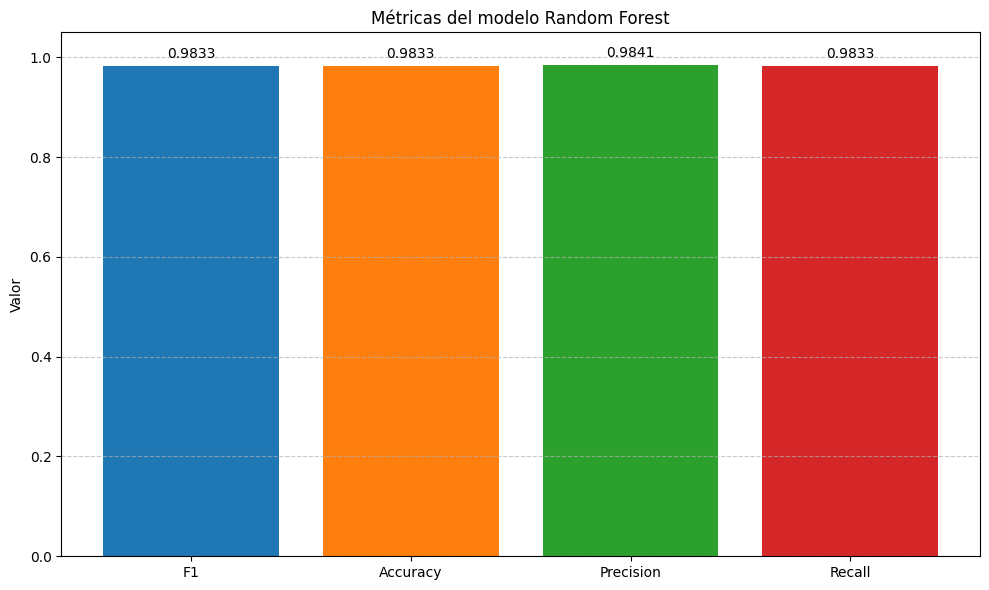

In [14]:
# Resultados obtenidos
modelos = ['F1', 'Accuracy', 'Precision', 'Recall']
valores = [f1, acc, prec, rec]
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, valores, color=colores)

# Etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.4f}",
             ha='center', va='bottom', fontsize=10)

plt.title('Métricas del modelo Random Forest')
plt.ylabel('Valor')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

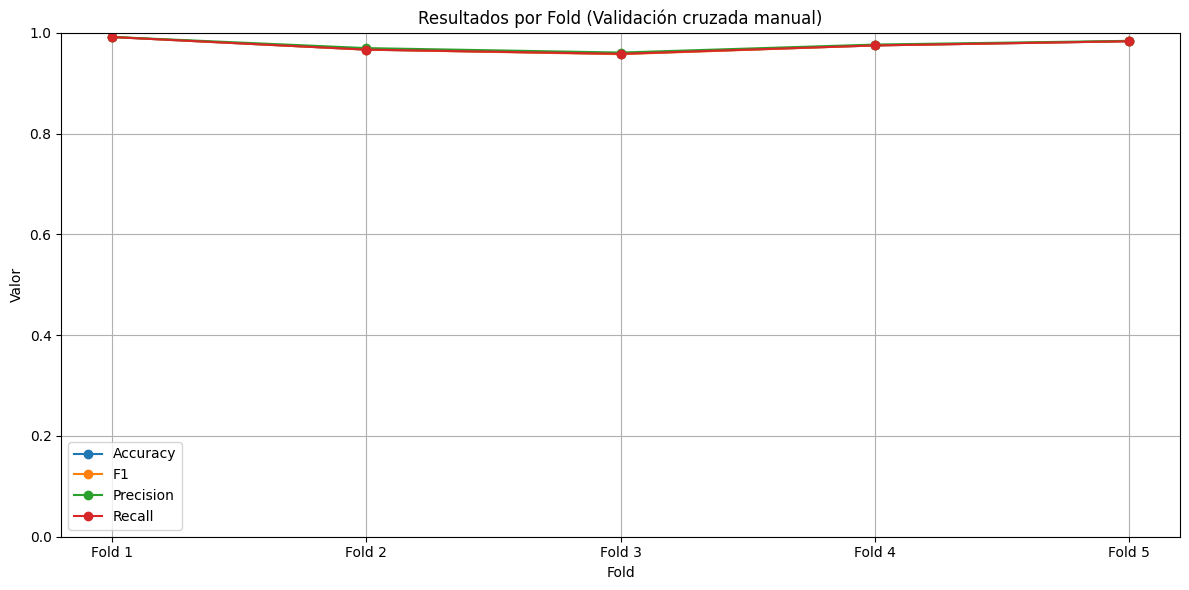

In [17]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

sample_df = sample_df.withColumn("num_tracks", col("playlist.num_tracks"))
assembler = VectorAssembler(inputCols=["num_tracks"], outputCol="features")
sample_df = assembler.transform(sample_df)

# ---------- Evaluadores ----------
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_rec  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# ---------- Diccionario para guardar métricas ----------
metricas_por_fold = {
    "Fold": [],
    "Accuracy": [],
    "F1": [],
    "Precision": [],
    "Recall": []
}

# ---------- Entrenamiento por fold ----------
k = 5
for fold in range(k):
    train_fold = sample_df.filter(col("fold") != fold)
    test_fold  = sample_df.filter(col("fold") == fold)

    rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
    model = rf.fit(train_fold)
    predictions = model.transform(test_fold)

    acc  = evaluator_acc.evaluate(predictions)
    f1   = evaluator_f1.evaluate(predictions)
    prec = evaluator_prec.evaluate(predictions)
    rec  = evaluator_rec.evaluate(predictions)

    metricas_por_fold["Fold"].append(f"Fold {fold+1}")
    metricas_por_fold["Accuracy"].append(acc)
    metricas_por_fold["F1"].append(f1)
    metricas_por_fold["Precision"].append(prec)
    metricas_por_fold["Recall"].append(rec)

# ---------- Graficar resultados ----------
plt.figure(figsize=(12, 6))
for metric in ["Accuracy", "F1", "Precision", "Recall"]:
    plt.plot(metricas_por_fold["Fold"], metricas_por_fold[metric], marker='o', label=metric)

plt.title("Resultados por Fold (Validación cruzada manual)")
plt.xlabel("Fold")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Aprendizaje Supervisado:
Menor robustez ante variaciones en los datos.

     RandomForestClassifier

Descripción:


Se utilizó un Grid Search con CrossValidator para optimizar hiperparámetros.

Resultados:


Menor cantidad de falsos positivos y falsos negativos.

Predicciones más estables ante nuevos datos.

Ventajas:

Excelente rendimiento en tareas supervisadas con bajo riesgo de sobreajuste.

Generaliza mejor que un solo árbol.


Desventajas:

Requiere más tiempo de entrenamiento y recursos computacionales.

No tan fácil de interpretar como un árbol único.



Con un **F1-score** de 0.9524 y una **Accuracy** igual, el Random Forest tiene **desempeño sobresaliente**. 

| Métrica       | Valor   | Interpretación del valor                                                                                                                              |
|---------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------|
| **Accuracy**  | 0.9524  | El 95.24 % de las predicciones son correctas. buen desempeño global, pero puede enmascarar errores en clases minoritarias.                     |
| **Precision** | 0.9588  | De todas las predicciones positivas, el 95.88 % son verdaderos positivos. Indica muy pocos falsos positivos.                                   |
| **Recall**    | 0.9524  | De todos los casos positivos reales, el 95.24 % fueron detectados. Alta capacidad para no perder instancias positivas.                         |
| **F1-score**  | 0.9524  | Media armónica entre precision y recall. Mantiene un equilibrio excelente sin sacrificar sensibilidad ni exactitud.                            |


### Fortalezas

- **Alta precisión y balance** (Accuracy ≈ F1 ≈ 0.95).  
- **Excelente poder discriminativo** (AUC ≈ 0.99).  
- **Bajo número de errores** en la matriz de confusión.

### Áreas de oportunidad

1. **Ajuste de umbral** según el coste relativo de falsos positivos vs. falsos negativos:  
   - Si los FN son más críticos,subir el recall.  
   - Si los FP son más costosos, subir la precision.

2. **Análisis de feature importances** :  
   - Reducir dimensionalidad concentrándote en las variables más relevantes.  
   - Detectar posibles fugas de información o sesgos.

3. **Curvas de aprendizaje**:  
   - Trazar F1/accuracy vs. número de árboles y vs. tamaño de muestra para identificar over-/under-fitting y optimizar recursos.

4. **Calibración de probabilidades**:  
   - Verificar que los scores de probabilidad correspondan a las frecuencias reales (p. ej. con Platt Scaling o Isotonic Regression).

---
## Conclusiones:
Durante el desarrollo de este proyecto, se propuso como objetivo principal analizar y clasificar las playlists contenidas en el dataset de Spotify, tomando en cuenta dos variables clave: si eran colaborativas o no, y el número total de canciones que incluían. A partir de esta clasificación, se definieron tres categorías de tamaño —corta, media y larga—, lo que permitió segmentar los datos en seis grupos distintos para su análisis.
Uno de los hallazgos más evidentes fue la clara prevalencia de playlists no colaborativas, especialmente aquellas de tamaño corto y medio. En cambio, las listas colaborativas conformaron solo una pequeña parte del total, lo que podría indicar que esta funcionalidad no es tan utilizada por los usuarios, al menos dentro de la muestra analizada. Esto plantea preguntas sobre la visibilidad, utilidad o incluso la experiencia de uso que ofrece Spotify en torno a las listas colaborativas.
La diferencia en el número de playlists por categoría también resultó considerable. Por ejemplo, mientras las listas personales de tamaño medio sobrepasaron las 460 mil entradas, las colaborativas —independientemente de su tamaño— no llegaron a las 11 mil. Esta disparidad no es menor, ya que puede tener un impacto directo en el entrenamiento de modelos de aprendizaje automático, en especial si no se toman medidas para contrarrestar la desproporción entre clases.
En conclusión, el análisis permitió identificar tendencias claras en la manera en que los usuarios utilizan las playlists. La fuerte inclinación hacia la creación individual, así como la preferencia por listas más compactas, refuerza la idea de que la plataforma se emplea principalmente como un espacio personal de curaduría musical. Estos resultados no solo son relevantes desde un punto de vista descriptivo, sino que también sirven como base para diseñar futuros modelos de recomendación más alineados con el comportamiento real de los usuarios.

